# Predict Future Sales

Мы просим вас спрогнозировать общий объем продаж для каждого продукта и магазина в следующем месяце. Решив эту задачу, вы сможете улучшить свои навыки в области data science.

Поля данных\
ID - идентификатор, представляющий кортеж (Магазин, товар) в тестовом наборе\
shop_id - уникальный идентификатор магазина\
item_id - уникальный идентификатор продукта\
item_category_id - уникальный идентификатор категории товара\
item_cnt_day - количество проданных товаров. Вы прогнозируете ежемесячную сумму этого\
item_price - текущая цена товара\
date - дата в формате dd/mm/yyyy
data_block_num - последовательный номер месяца, используемый для удобства. Январь 2013 года-0, Февраль 2013 года-1,..., Октябрь 2015 года-33\
item_name - название товара\
shop_name - название магазина\
item_category_name - имя категории товара

In [51]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 1 Подготовительный этап

## Чтение данных

sales_train.csv - обучающий набор. Ежедневные исторические данные с января 2013 года по октябрь 2015 года. \
test.csv - набор тестов. Вам необходимо спрогнозировать продажи этих магазинов и продуктов на ноябрь 2015 года.\
items.csv - дополнительная информация о товарах / продуктах.\
item_categories.csv - дополнительная информация о категориях элементов.\
shops.csv - дополнительная информация о магазинах.

In [52]:
items  = pd.read_csv('data/items.csv')
train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
item_category = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')

## Вспомогательные функции

Функция для анализа содержимого в dataframe

In [53]:
def show_data_info(data):
    print("-----------------Первые 7 записей----------------------")
    print(data.head(7))
    print("--------------------Информация-------------------------")
    print(data.info())
    print("-------------------Типы данных-------------------------")
    print(data.dtypes)
    print("--------------------Пропуски---------------------------")
    print(data.isnull().sum())
    print("-----------------Значнеия NULL-------------------------")
    print(data.isna().sum())
    print("----------------Форма данных---------------------------")
    print(data.shape)

Функция для удаления повторов

In [54]:
def delete_duplicate(data, subset):
    print('До удаления:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(subset,keep='first', inplace=True)
    data.reset_index(drop=True, inplace=True)
    print('После удаления:', data.shape)
    after = data.shape[0]
    print('Удалено:', before-after)

 Функция для вывода на экран метрик модели

In [55]:
def show_metrics(y_real, y_predicted):
    print(f'MSE: {mean_squared_error(y_real, y_predicted)}')
    print(f'RMSE: {mean_squared_error(y_real, y_predicted, squared=False)}')
    print(f'MAE: {mean_absolute_error(y_real, y_predicted)}')
    print(f'Коэффициент детерминации: {r2_score(y_real, y_predicted)}')

Функция для вывода на экран визуализации качества модели

In [111]:
def plot_model_results(model_name, y_real, y_predicted):
    x_ax = range(len(y_predicted[:1000]))
    plt.plot(x_ax, y_real[:1000], label="Реальное значение")
    plt.plot(x_ax,y_predicted[:1000], label="Предсказанное значение")

    plt.title(model_name)
    plt.ylabel('Количество проданных товаров')
    plt.xlabel('Объекты')
    plt.legend()
    plt.show()

# 2. Анализ данных

## 2.1 Sales Train Data

In [57]:
show_data_info(train)

-----------------Первые 7 записей----------------------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
--------------------Информация-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_

## 2.2 Test Data

In [58]:
show_data_info(test)

-----------------Первые 7 записей----------------------
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
5   5        5     5039
6   6        5     5041
--------------------Информация-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None
-------------------Типы данных-------------------------
ID         int64
shop_id    int64
item_id    int64
dtype: object
--------------------Пропуски---------------------------
ID         0
shop_id    0
item_id    0
dtype: int64
-----------------Значнеия NULL-------------------------
ID         0
shop_id    0
item_id    0
dtype: int64
----------------Форма

## 2.3 Item

In [59]:
show_data_info(items)

-----------------Первые 7 записей----------------------
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   
5  ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...        5   
6           ***УДАР ПО ВОРОТАМ (UNI)               D        6   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
5                40  
6                40  
--------------------Информация-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------

## 2.4 Item Category

In [60]:
show_data_info(item_category)

-----------------Первые 7 записей----------------------
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
5      Аксессуары - PSVita                 5
6    Аксессуары - XBOX 360                 6
--------------------Информация-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
-------------------Типы данных-------------------------
item_category_name    object
item_category_id       int64
dtype: object
--------------------Пропуски-----------------------

## 2.5 Shops

In [61]:
show_data_info(shops)

-----------------Первые 7 записей----------------------
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
5          Вологда ТРЦ "Мармелад"        5
6      Воронеж (Плехановская, 13)        6
--------------------Информация-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
-------------------Типы данных-------------------------
shop_name    object
shop_id       int64
dtype: object
--------------------Пропуски---------------------------
shop_name    0
shop_id      0
dtype: int64
-----------------Значн

 Изучим продажу товаров в каждом из магазинов

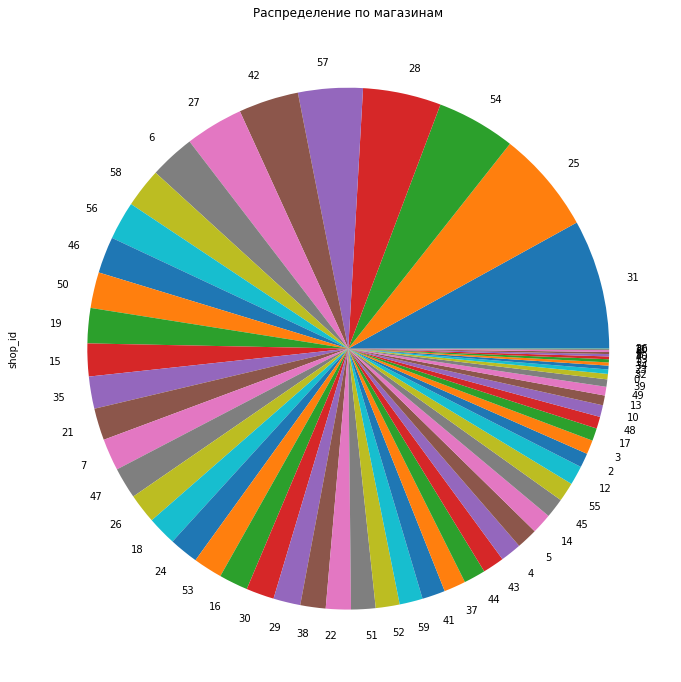

In [62]:
train["shop_id"].value_counts().plot(kind='pie')
plt.title('Распределение по магазинам');

# 3. Удаление аномалий

Из выше сказанного видно, что в дата сете отсутвуют пустые значения

In [63]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


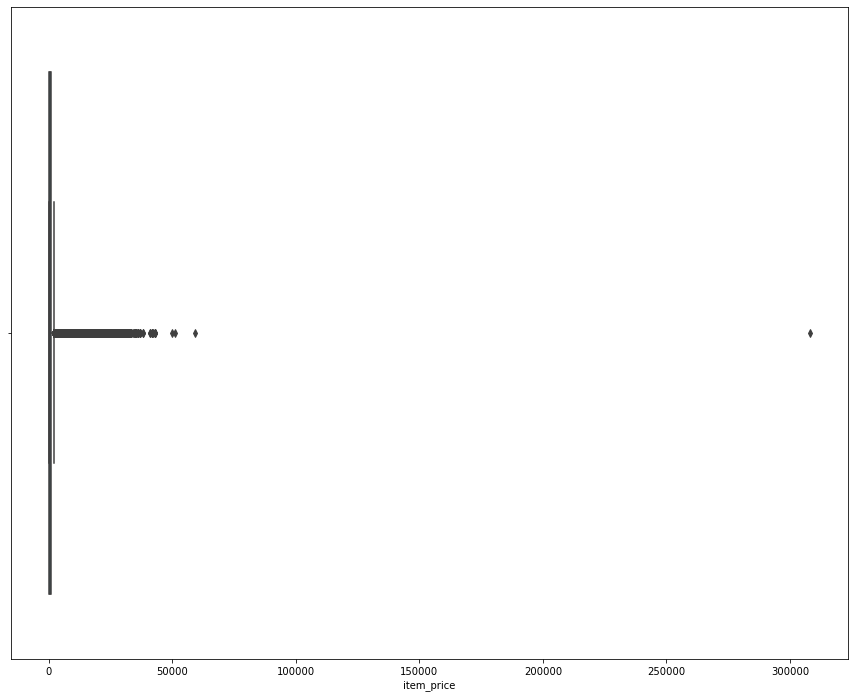

In [64]:
 sns.boxplot(train["item_price"]);

Удалим повторы

In [65]:
subset = ['date', 'date_block_num', 'shop_id', 'item_id','item_cnt_day']
delete_duplicate(train, subset = subset)

До удаления: (2935849, 6)
После удаления: (2935825, 6)
Удалено: 24


Удалим аномалии.

In [66]:
quantile_down = train["item_price"].quantile(0.0001)
quantile_up = train["item_price"].quantile(0.9999)
print('До удаления аномалий:',train.shape)

До удаления аномалий: (2935825, 6)


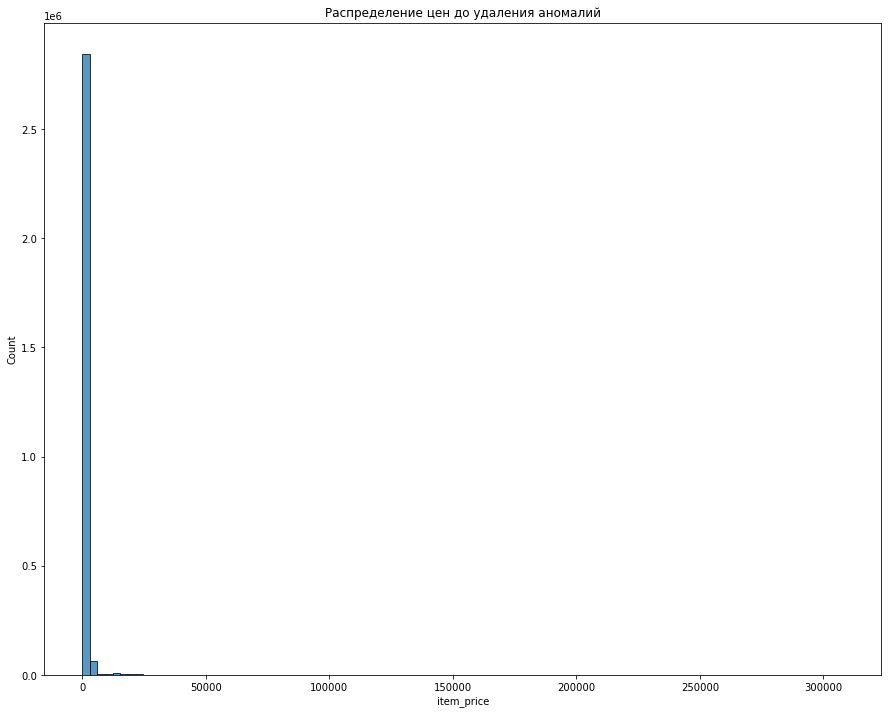

In [67]:
sns.histplot(train["item_price"], bins=100);
plt.title("Распределение цен до удаления аномалий");

In [68]:
train = train[(quantile_down < train["item_price"]) & (quantile_up > train["item_price"])]

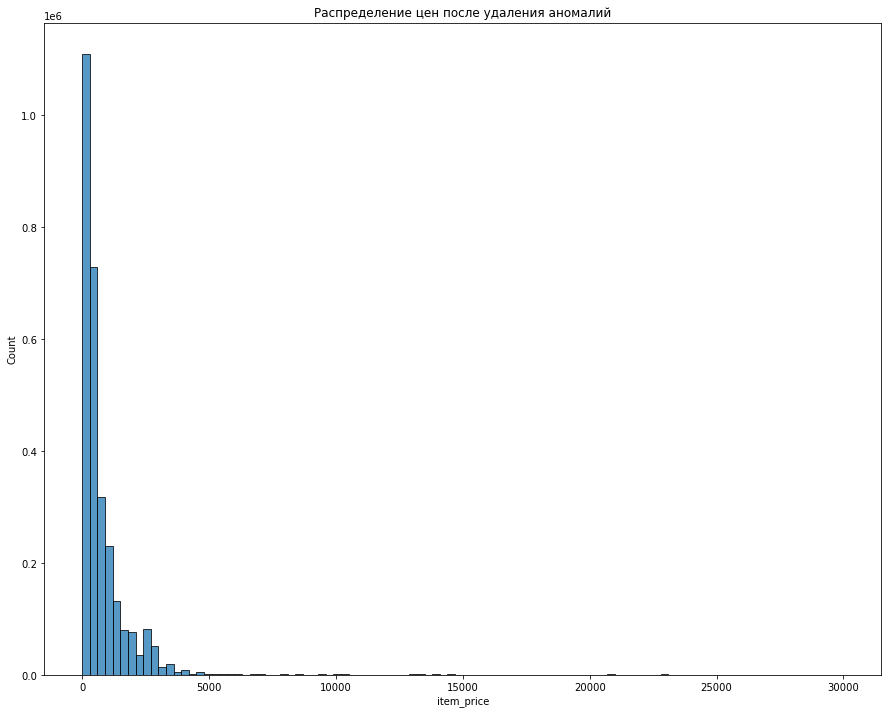

In [69]:
sns.histplot(train["item_price"], bins=100);
plt.title("Распределение цен после удаления аномалий");

In [70]:
print('Размер после удаления аномалий:',train.shape)

Размер после удаления аномалий: (2932444, 6)


In [71]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2932444.0,14.576620,9.422087,0.0,7.0,14.0,23.0,33.0
shop_id,2932444.0,33.002187,16.226068,0.0,22.0,31.0,47.0,59.0
item_id,2932444.0,10193.631587,6325.854378,0.0,4474.0,9305.0,15687.0,22169.0
item_price,2932444.0,886.987527,1678.660993,0.2,249.0,399.0,999.0,29989.5
item_cnt_day,2932444.0,1.242569,2.620192,-22.0,1.0,1.0,1.0,2169.0


Изучим взаимную корреляцию признаков

In [72]:
train.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019351,0.009885,0.093115,0.009453
shop_id,0.019351,1.000000,0.029413,-0.024062,-0.005251
item_id,0.009885,0.029413,1.000000,-0.138121,0.016622
item_price,0.093115,-0.024062,-0.138121,1.000000,0.011668
item_cnt_day,0.009453,-0.005251,0.016622,0.011668,1.000000


Сильных зависимостей нет

# 3. Количество продаж в месяц

Покажим сумму продаж в каждом месяце

In [73]:
print(train.groupby('date_block_num').sum()['item_cnt_day'])

date_block_num
0     131475.0
1     128088.0
2     147139.0
3     107189.0
4     106969.0
5     123075.0
6     116018.0
7     124640.0
8     133329.0
9     127540.0
10    130008.0
11    183340.0
12    116899.0
13    109685.0
14    115293.0
15     96555.0
16     97788.0
17     97429.0
18     91278.0
19    102719.0
20     99207.0
21    107422.0
22    117843.0
23    168751.0
24    110918.0
25     84142.0
26     81991.0
27     77821.0
28     72294.0
29     64104.0
30     63137.0
31     66005.0
32     72730.0
33     70943.0
Name: item_cnt_day, dtype: float64


Покажем сумму продаж в месяц в виде гистраграммы 

Text(0.5, 0, 'Цена')

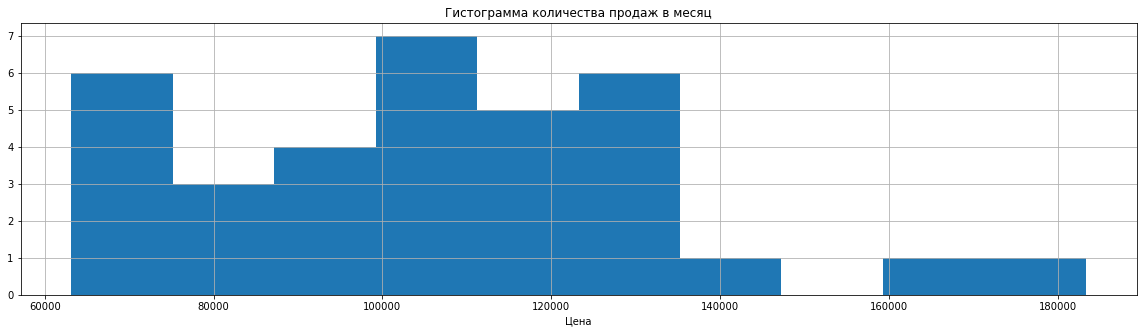

In [74]:
train.groupby('date_block_num').sum()['item_cnt_day'].hist(figsize = (20,5))
plt.title('Гистограмма количества продаж в месяц')
plt.xlabel('Цена')

# 4. Сопоставьте элементов

In [75]:
category_list = list(item_category.item_category_name)

for i in range(1,8):
    category_list[i] = 'Аксессуары '

for i in range(10,18):
    category_list[i] = 'Консоли'

for i in range(18,25):
    category_list[i] = 'Игры для консолей'

for i in range(26,28):
    category_list[i] = 'Мобильные игры'

for i in range(28,32):
    category_list[i] = 'CD игры'

for i in range(32,37):
    category_list[i] = 'Карточки'

for i in range(37,43):
    category_list[i] = 'Кино'

for i in range(43,55):
    category_list[i] = 'Книги'

for i in range(55,61):
    category_list[i] = 'Музыка'

for i in range(61,73):
    category_list[i] = 'Подарки'

for ind in range(73,79):
    category_list[i] = 'ПО'


item_category['category'] = category_list
item_category.head()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


# 5. Преобразование типов данных 

Конвертируем столбец "дата" из типа "object" в тип "дата"

In [76]:
train['date'] = pd.to_datetime(train.date,format="%d.%m.%Y")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


Сводка по месяцам

In [77]:
train_pivot_table = train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', 
                         values='item_cnt_day',aggfunc='sum').fillna(0.0)
train_pivot_table.head()

date_block_num    0     1    2    3    4    5    6    7    8    9   ...   24  \
shop_id item_id                                                     ...        
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

Добавляем категории

In [78]:
train_cleaned = train_pivot_table.reset_index()
train_cleaned['shop_id']= pd.to_numeric(train_cleaned['shop_id'])
train_cleaned['item_id']= pd.to_numeric(train_cleaned['item_id'])

item_to_cat = items.merge(item_category[['item_category_id','category']], how="inner",
                             on="item_category_id")[['item_id','category']]
train_cleaned = train_cleaned.merge(item_to_cat, how="inner", on="item_id")

Кодируем категории

In [79]:
number = preprocessing.LabelEncoder()
train_cleaned[['category']] = number.fit_transform(train_cleaned.category)
train_cleaned = train_cleaned[['shop_id', 'item_id', 'category'] + list(range(34))]
train_cleaned.head()

,shop_id,item_id,category,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,8,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,8,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,8,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,8,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 6. Построение моделей

Проверка итогового набора данных

In [80]:
print("-----------------Первые 7 записей----------------------")
print(train_cleaned.head(7))
print("-------------------Типы данных-------------------------")
print(train_cleaned.dtypes)
print("--------------------Значнеия NULL---------------------------")
print(train_cleaned.isnull().sum())
print("-----------------Значнеия NAN-------------------------")
print(train_cleaned.isna().sum())
print("----------------Форма данных---------------------------")
print(train_cleaned.shape)

-----------------Первые 7 записей----------------------
   shop_id  item_id  category    0     1     2    3    4    5    6  ...   24  \
0        0       30         8  0.0  31.0   0.0  0.0  0.0  0.0  0.0  ...  0.0   
1        1       30         8  0.0  10.0   0.0  0.0  0.0  0.0  0.0  ...  0.0   
2        2       30         8  0.0   0.0   1.0  0.0  0.0  1.0  0.0  ...  0.0   
3        3       30         8  0.0   4.0   5.0  2.0  2.0  1.0  0.0  ...  0.0   
4        4       30         8  0.0   7.0   3.0  0.0  0.0  0.0  0.0  ...  0.0   
5        5       30         8  0.0   5.0   7.0  1.0  0.0  0.0  0.0  ...  0.0   
6        6       30         8  0.0  28.0  10.0  4.0  0.0  1.0  0.0  ...  1.0   

    25   26   27   28   29   30   31   32   33  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5  0.0  0

Разделение выборок

In [81]:
X_train = train_cleaned.drop(33, 1)
y_train = train_cleaned[33]
print(X_train.shape)
print(y_train.shape)

(423589, 36)
(423589,)


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
print (X_train.shape,  y_train.shape)
print (X_test.shape,  y_test.shape)

(296512, 36) (296512,)
(127077, 36) (127077,)


In [83]:
real_to_predict = test
real_to_predict = test.merge(train_cleaned, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
real_to_predict.head()

,ID,shop_id,item_id,category,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Переход на один месяц вперед

In [84]:
d = dict(zip(real_to_predict.columns[4:],list(np.array(list(real_to_predict.columns[4:])) - 1)))

real_to_predict  = real_to_predict.rename(d, axis = 1)

## 6.1  Модель RandomForestRegressor

In [85]:
model_rfr = RandomForestRegressor().fit(X_train, y_train)

 Оценка качества модели по метрикам

In [86]:
y_pred_rfr = model_rfr.predict(X_test)
show_metrics(y_test, y_pred_rfr)

MSE: 3.2446968027259064
RMSE: 1.8013041949448478
MAE: 0.17192017438246102
Коэффициент детерминации: 0.44457354544359107


 Визуализация реальных и предсказанных значений

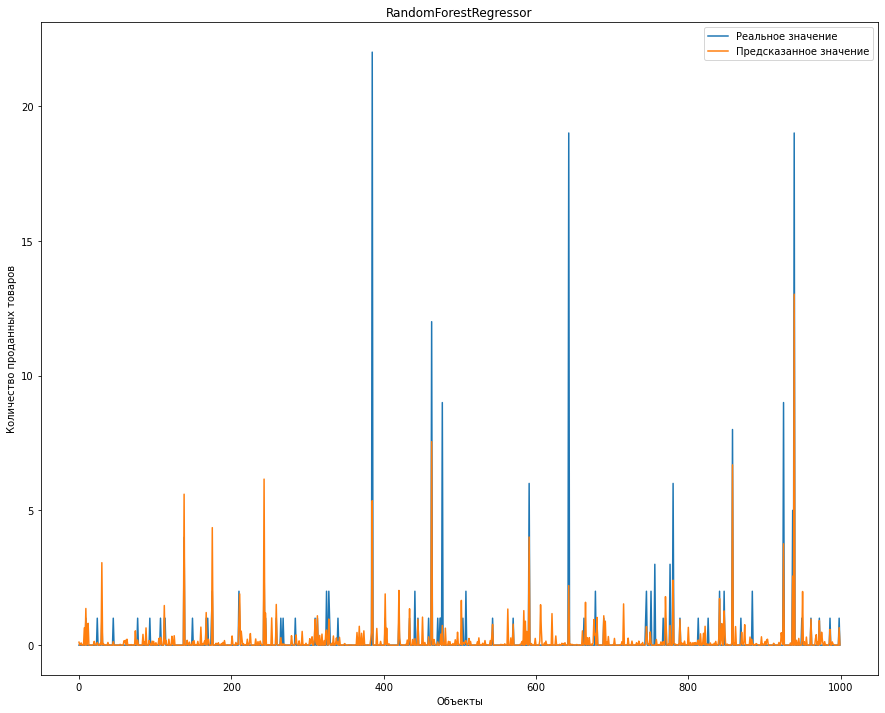

In [114]:
plot_model_results('RandomForestRegressor', y_test, y_pred_rfr)

Предсказания для тестовой выборки

In [88]:
predict_rfr = model_rfr.predict(real_to_predict.iloc[:, (real_to_predict.columns != 'ID') 
                                                     & (real_to_predict.columns != -1)].values)

Нормализуем наш прогноз в пределах [0-20]

In [89]:
predicted_rfr = pd.DataFrame({'ID':real_to_predict.ID,'item_cnt_month':list(map(lambda x: min(20,max(x,0)),
                                                                                list(predict_rfr)))})
predicted_rfr.head()

,ID,item_cnt_month
0,0,0.27
1,1,0.00
2,2,0.56
3,3,0.02
4,4,0.01


Запись результатов в файл для их отправки

In [90]:
predicted_rfr.to_csv('results/Predict_Sales_rfr.csv',index=False)

## 6.2 XGBRegressor

In [91]:
model_xgb = xgb.XGBRegressor().fit(X_train, y_train)

Оценка качества модели по метрикам

In [92]:
y_pred_xgb = model_xgb.predict(X_test)
show_metrics(y_test, y_pred_xgb)

MSE: 3.428920817891728
RMSE: 1.851734543041126
MAE: 0.19768889663244066
Коэффициент детерминации: 0.41303812077718294


 Визуализация реальных и предсказанных значений

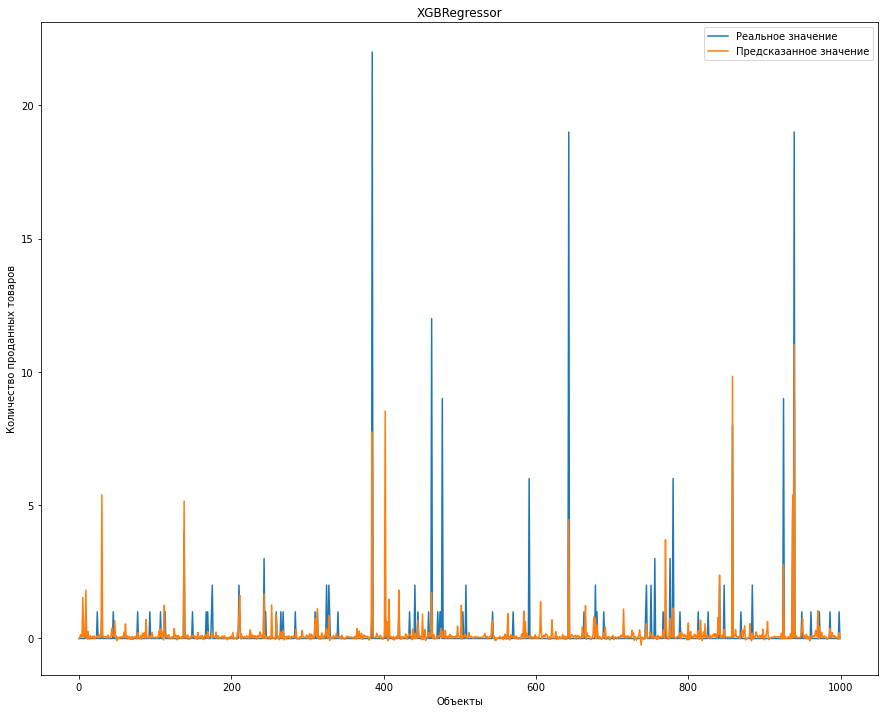

In [113]:
plot_model_results('XGBRegressor', y_test, y_pred_xgb)

Предсказания для тестовой выборки

In [94]:
predict_xgb = model_xgb.predict(real_to_predict.iloc[:, (real_to_predict.columns != 'ID') & (
    real_to_predict.columns != -1)].values)

Нормализуем наш прогноз в пределах [0-20]

In [95]:
predicted_xgb = pd.DataFrame({'ID':real_to_predict.ID,'item_cnt_month':list(map(lambda x: min(20,max(x,0)), 
                                                                                list(predict_xgb))) })
predicted_xgb.head()

,ID,item_cnt_month
0,0,0.340111
1,1,0.098882
2,2,0.606657
3,3,0.125540
4,4,0.098882


Запись результатов в файл для их отправки

In [96]:
predicted_xgb.to_csv('results/Predict_Sales_xgb.csv',index=False)

## 6.3 GradientBoostingRegressor

In [97]:
model_gbr = GradientBoostingRegressor().fit(X_train, y_train)

 Оценка качества модели по метрикам

In [98]:
y_pred_gbr = model_gbr.predict(X_test)
show_metrics(y_test, y_pred_gbr)

MSE: 3.2962795773496163
RMSE: 1.815565911045263
MAE: 0.22538396318621315
Коэффициент детерминации: 0.43574361791342553


Визуализация реальных и предсказанных значений

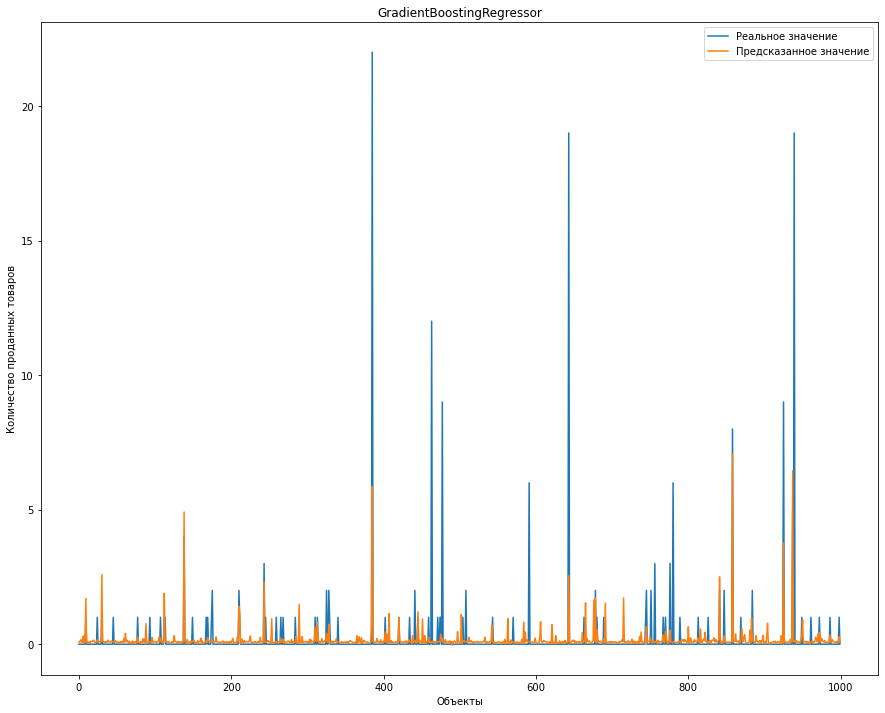

In [112]:
plot_model_results('GradientBoostingRegressor', y_test, y_pred_gbr)

Предсказания для тестовой выборки

In [100]:
predict_gbr = model_gbr.predict(real_to_predict.iloc[:, (real_to_predict.columns != 'ID') & 
                                                     (real_to_predict.columns != -1)].values)

Нормализуем наш прогноз в пределах [0-20]

In [101]:
predicted_gbr = pd.DataFrame({'ID':real_to_predict.ID,'item_cnt_month':list(map(lambda x: min(20,max(x,0)), 
                                                                                list(predict_gbr)))})
predicted_gbr.head()

,ID,item_cnt_month
0,0,0.357401
1,1,0.105804
2,2,0.863977
3,3,0.136400
4,4,0.105804


Запись результатов в файл для их отправки

In [102]:
predicted_gbr.to_csv('results/Predict_Sales_gbr.csv',index=False)

## 6.4 CatBoostRegressor

In [103]:
model_cbr = CatBoostRegressor(verbose=False).fit(X_train, y_train)

Оценка качества модели по метрикам

In [104]:
y_pred_cbr = model_cbr.predict(X_test)
show_metrics(y_test, y_pred_cbr)

MSE: 3.760027391281701
RMSE: 1.9390790059411454
MAE: 0.21509148364820405
Коэффициент детерминации: 0.3563593734798043


 Визуализация реальных и предсказанных значений

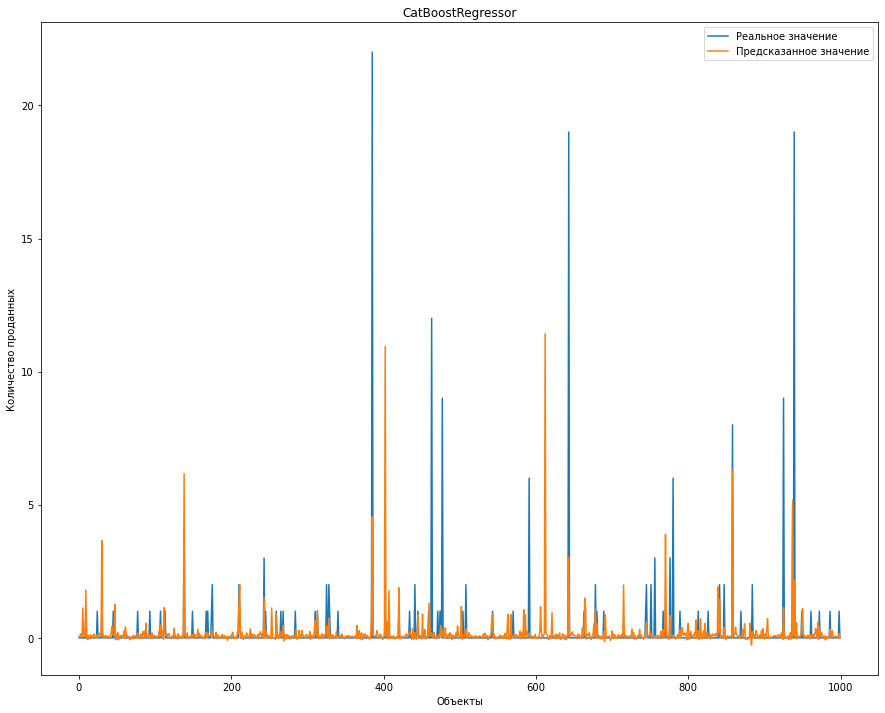

In [110]:
plot_model_results('CatBoostRegressor', y_test, y_pred_cbr)

Предсказания для тестовой выборки

In [106]:
predict_cbr = model_cbr.predict(real_to_predict.iloc[:, (real_to_predict.columns != 'ID') 
                                                     & (real_to_predict.columns != -1)].values)

Нормализуем наш прогноз в пределах [0-20]

In [107]:
predicted_cbr = pd.DataFrame({'ID':real_to_predict.ID,'item_cnt_month':list(map(lambda x: min(20,max(x,0)), 
                                                                                list(predict_cbr)))})
predicted_cbr.head()

,ID,item_cnt_month
0,0,0.381607
1,1,0.153402
2,2,0.655837
3,3,0.169866
4,4,0.153402


Запись результатов в файл для их отправки

In [108]:
predicted_cbr.to_csv('results/Predict_Sales_cbr.csv',index=False)